<a href="https://colab.research.google.com/github/shraddha0822/SMS-Spam-Detection-using-Tensorflow/blob/main/SMS_Spam_Detection_using_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# Reading the data
df = pd.read_csv("/content/spam.csv",encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
# The dataset contains three unnamed columns with null values. So we drop those columns and rename the columns v1 and v2 to label and Text
# Since the target variable is in string form, we will encode it numerically using pandas function .map().
df = df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)
df = df.rename(columns={'v1':'label','v2':'Text'})
df['label_enc'] = df['label'].map({'ham':0,'spam':1})
df.head()

,label,Text,label_enc
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


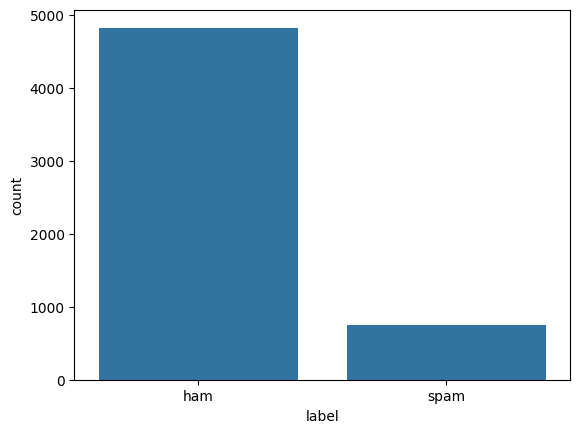

In [ ]:
sns.countplot(x=df['label'])
plt.show()

In [ ]:
# Since we are going to use embeddings in our deep learning model, we need not balance the data.

In [ ]:
# Find average number of tokens in all sentences
avg_words_len=round(sum([len(i.split()) for i in df['Text']])/len(df['Text']))
print(avg_words_len)

15


In [ ]:
# Finding Total no of unique words in corpus
s = set()
for sent in df['Text']:
  for word in sent.split():
    s.add(word)
total_words_length=len(s)
print(total_words_length)

15585


In [ ]:
# Splitting data for Training and testing
from sklearn.model_selection import train_test_split

X, y = np.asanyarray(df['Text']), np.asanyarray(df['label_enc'])
new_df = pd.DataFrame({'Text': X, 'label': y})
X_train, X_test, y_train, y_test = train_test_split(
	new_df['Text'], new_df['label'], test_size=0.2, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4457,), (4457,), (1115,), (1115,))

In [ ]:
# First, we build a baseline model and then we’ll try to beat the performance of the baseline model using deep learning models (embeddings, LSTM, etc)
# Here, we choose MultinomialNB(), which performs well for text classification when the features are discrete like word counts of the words or tf-idf vectors.
# The tf-idf is a measure that tells how important or relevant a word is the document.

In [ ]:
# Building the model

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,accuracy_score

tfidf_vec = TfidfVectorizer().fit(X_train)
X_train_vec,X_test_vec = tfidf_vec.transform(X_train),tfidf_vec.transform(X_test)

baseline_model = MultinomialNB()
baseline_model.fit(X_train_vec,y_train)

MultinomialNB()

In [ ]:
# Performance of baseline model

nb_accuracy = accuracy_score(y_test, baseline_model.predict(X_test_vec))
print(nb_accuracy)
print(classification_report(y_test, baseline_model.predict(X_test_vec)))

0.9623318385650225
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       965
           1       1.00      0.72      0.84       150

    accuracy                           0.96      1115
   macro avg       0.98      0.86      0.91      1115
weighted avg       0.96      0.96      0.96      1115



Now, we’ll create a custom text vectorization layer using TensorFlow.

In [ ]:
from tensorflow.keras.layers import TextVectorization

MAXTOKENS=total_words_length #maximum size of the vocabulary which was found earlier
OUTPUTLEN=avg_words_len #length to which the sentences should be padded irrespective of the sentence length.

text_vec = TextVectorization(
	max_tokens=MAXTOKENS,
	standardize='lower_and_strip_punctuation',
	output_mode='int',
	output_sequence_length=OUTPUTLEN
)
text_vec.adapt(X_train)

In [ ]:
embedding_layer = layers.Embedding(
	input_dim=MAXTOKENS, #size of vocabulary
	output_dim=128, #dimension of the embedding layer i.e, the size of the vector in which the words will be embedded
	embeddings_initializer='uniform',
	input_length=OUTPUTLEN #length of input sequences
)

 Building and compiling model 1 using the Tensorflow Functional API

In [ ]:
input_layer = layers.Input(shape=(1,), dtype=tf.string)
vec_layer = text_vec(input_layer)
embedding_layer_model = embedding_layer(vec_layer)
x = layers.GlobalAveragePooling1D()(embedding_layer_model)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)
model_1 = keras.Model(input_layer, output_layer)

model_1.compile(optimizer='adam', loss=keras.losses.BinaryCrossentropy(
	label_smoothing=0.5), metrics=['accuracy'])

In [ ]:
# Summary of model 1

model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 15)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 15, 128)           1994880   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 32)                4128  

In [ ]:
# Training the model 1

history_1 = model_1.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test), validation_steps=int(0.2*len(X_test)))

Epoch 1/5
140/140 [==============================] - 10s 56ms/step - loss: 0.6009 - accuracy: 0.9197 - val_loss: 0.5765 - val_accuracy: 0.9731
Epoch 2/5
140/140 [==============================] - 6s 46ms/step - loss: 0.5698 - accuracy: 0.9872 - val_loss: 0.5732 - val_accuracy: 0.9830
Epoch 3/5
140/140 [==============================] - 7s 52ms/step - loss: 0.5655 - accuracy: 0.9969 - val_loss: 0.5723 - val_accuracy: 0.9839
Epoch 4/5
140/140 [==============================] - 6s 43ms/step - loss: 0.5641 - accuracy: 0.9982 - val_loss: 0.5725 - val_accuracy: 0.9839
Epoch 5/5
140/140 [==============================] - 7s 49ms/step - loss: 0.5634 - accuracy: 0.9991 - val_loss: 0.5725 - val_accuracy: 0.9848


<Axes: >

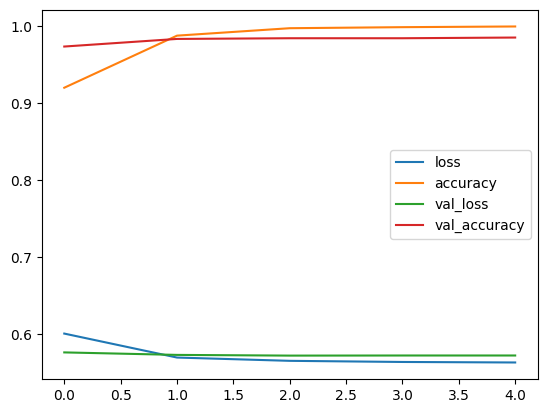

In [ ]:
# Plotting the history of model 1

pd.DataFrame(history_1.history).plot()

Creating helper functions for compiling, fitting, and evaluating the model performance.

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def compile_model(model):
    '''
    simply compiles the model with adam optimizer
    '''
    model.compile(optimizer=keras.optimizers.Adam(),
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])

def fit_model(model, epochs, X_train=X_train, y_train=y_train,
              X_test=X_test, y_test=y_test):
    '''
    fits the model with given epochs, train
    and test data
    '''
    history = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        validation_data=(X_test, y_test),
                        validation_steps=int(0.2*len(X_test)))
    return history

def evaluate_model(model, X, y):
    '''
    evaluates the model and returns accuracy,
    precision, recall and f1-score
    '''
    y_preds = np.round(model.predict(X))
    accuracy = accuracy_score(y, y_preds)
    precision = precision_score(y, y_preds)
    recall = recall_score(y, y_preds)
    f1 = f1_score(y, y_preds)

    model_results_dict = {'accuracy': accuracy,
                          'precision': precision,
                          'recall': recall,
                          'f1-score': f1}

    return model_results_dict

Model -2 Bidirectional LSTM

In [ ]:
input_layer = layers.Input(shape=(1,), dtype=tf.string)
vec_layer = text_vec(input_layer)
embedding_layer_model = embedding_layer(vec_layer)
bi_lstm = layers.Bidirectional(layers.LSTM(
    64, activation='tanh', return_sequences=True))(embedding_layer_model)
lstm = layers.Bidirectional(layers.LSTM(64))(bi_lstm)
flatten = layers.Flatten()(lstm)
dropout = layers.Dropout(.1)(flatten)
x = layers.Dense(32, activation='relu')(dropout)
output_layer = layers.Dense(1, activation='sigmoid')(x)
model_2 = keras.Model(input_layer, output_layer)

compile_model(model_2)  # compile the model
history_2 = fit_model(model_2, epochs=5)  # fit the model

Epoch 1/5
140/140 [==============================] - 24s 106ms/step - loss: 0.0623 - accuracy: 0.9805 - val_loss: 0.0941 - val_accuracy: 0.9830
Epoch 2/5
140/140 [==============================] - 14s 101ms/step - loss: 0.0020 - accuracy: 0.9993 - val_loss: 0.0952 - val_accuracy: 0.9830
Epoch 3/5
140/140 [==============================] - 13s 89ms/step - loss: 2.0679e-04 - accuracy: 1.0000 - val_loss: 0.1077 - val_accuracy: 0.9865
Epoch 4/5
140/140 [==============================] - 12s 84ms/step - loss: 2.5161e-05 - accuracy: 1.0000 - val_loss: 0.1172 - val_accuracy: 0.9857
Epoch 5/5
140/140 [==============================] - 12s 87ms/step - loss: 1.5317e-05 - accuracy: 1.0000 - val_loss: 0.1220 - val_accuracy: 0.9857


Model -3 Transfer Learning with USE Encoder

In [ ]:
import tensorflow_hub as hub

# model with Sequential api
model_3 = keras.Sequential()

# universal-sentence-encoder layer
# directly from tfhub
use_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                           trainable=False,
                           input_shape=[],
                           dtype=tf.string,
                           name='USE')
model_3.add(use_layer)
model_3.add(layers.Dropout(0.2))
model_3.add(layers.Dense(64, activation=keras.activations.relu))
model_3.add(layers.Dense(1, activation=keras.activations.sigmoid))

compile_model(model_3)

history_3 = fit_model(model_3, epochs=5)

Epoch 1/5
140/140 [==============================] - 7s 24ms/step - loss: 0.2971 - accuracy: 0.9242 - val_loss: 0.1142 - val_accuracy: 0.9704
Epoch 2/5
140/140 [==============================] - 3s 21ms/step - loss: 0.0811 - accuracy: 0.9789 - val_loss: 0.0733 - val_accuracy: 0.9758
Epoch 3/5
140/140 [==============================] - 4s 29ms/step - loss: 0.0574 - accuracy: 0.9827 - val_loss: 0.0585 - val_accuracy: 0.9830
Epoch 4/5
140/140 [==============================] - 3s 23ms/step - loss: 0.0475 - accuracy: 0.9868 - val_loss: 0.0540 - val_accuracy: 0.9821
Epoch 5/5
140/140 [==============================] - 3s 21ms/step - loss: 0.0417 - accuracy: 0.9861 - val_loss: 0.0535 - val_accuracy: 0.9821


Analyzing our Models' Performance

In [ ]:
baseline_model_results = evaluate_model(baseline_model, X_test_vec, y_test)
model_1_results = evaluate_model(model_1, X_test, y_test)
model_2_results = evaluate_model(model_2, X_test, y_test)
model_3_results = evaluate_model(model_3, X_test, y_test)

total_results = pd.DataFrame({'MultinomialNB Model':baseline_model_results,
                             'Custom-Vec-Embedding Model':model_1_results,
                             'Bidirectional-LSTM Model':model_2_results,
                             'USE-Transfer learning Model':model_3_results}).transpose()

total_results

35/35 [==============================] - 1s 11ms/step


,accuracy,precision,recall,f1-score
MultinomialNB Model,0.962332,1.000000,0.720000,0.837209
Custom-Vec-Embedding Model,0.982960,0.978102,0.893333,0.933798
Bidirectional-LSTM Model,0.985650,0.992647,0.900000,0.944056
USE-Transfer learning Model,0.982063,0.964286,0.900000,0.931034


Which metric is better?
False negatives and false positives are significant in this problem. Precision and recall are the metrics that allow us the ability to calculate them, but there is one more, ‘f1-score.’
The f1-score is the harmonic mean of accuracy and recall. Thus, we can get both with a single shot.
Bidirectional-LSTM Model gives the best accuracy and f1-score.